## Import Packages & Util Functions

In [271]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

def make_out_dir(out_dir):
    if not os.path.exist(out_dir):
        os.makedirs(out_dir)

## Camera Calibration

### Calibrating a Camera

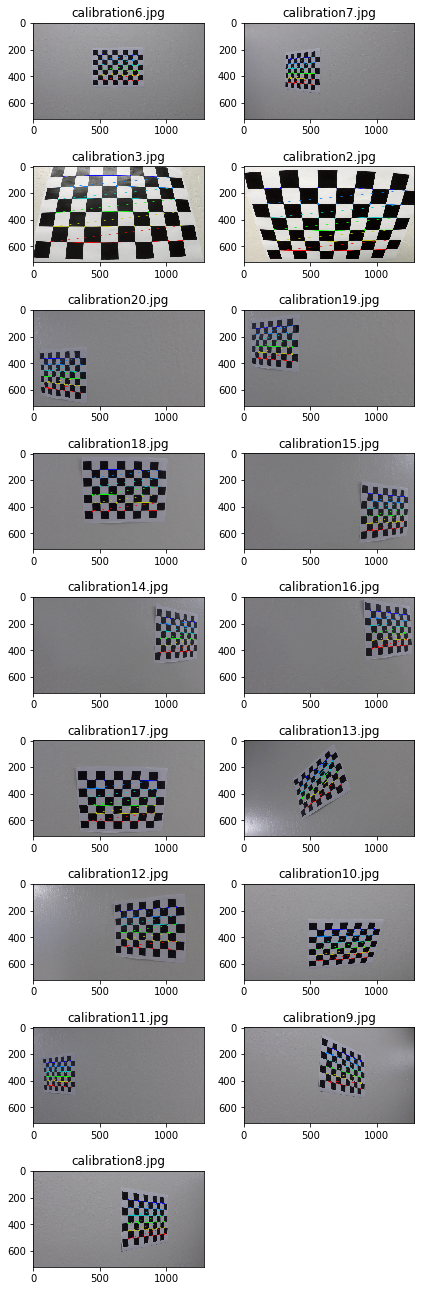

In [272]:
import glob
import pickle

# Read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
images_len = len(images)

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare objects points, like (0,0,0), (1,0,0), (2,0,0) ...., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

fig = plt.figure(figsize=(6, 20))
idx = 1
for fname in images:
    # read in each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        ax = fig.add_subplot(10, np.ceil(images_len/10), idx)
        ax.imshow(img)
        ax.set_title(fname.split('/')[-1])
        idx += 1
        
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.tight_layout()
fig.show()

objpoints_org = objpoints.copy()
imgpoints_org = imgpoints.copy()

# Calibrate a camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save objpoints and imgpoints
with open("wide_dist_pickle.p", 'wb') as f:
    pickle.dump({'objpoints': objpoints, 'imgpoints':imgpoints, 'mtx':mtx, 'dist':dist}, f)


### Correcting for Distortion

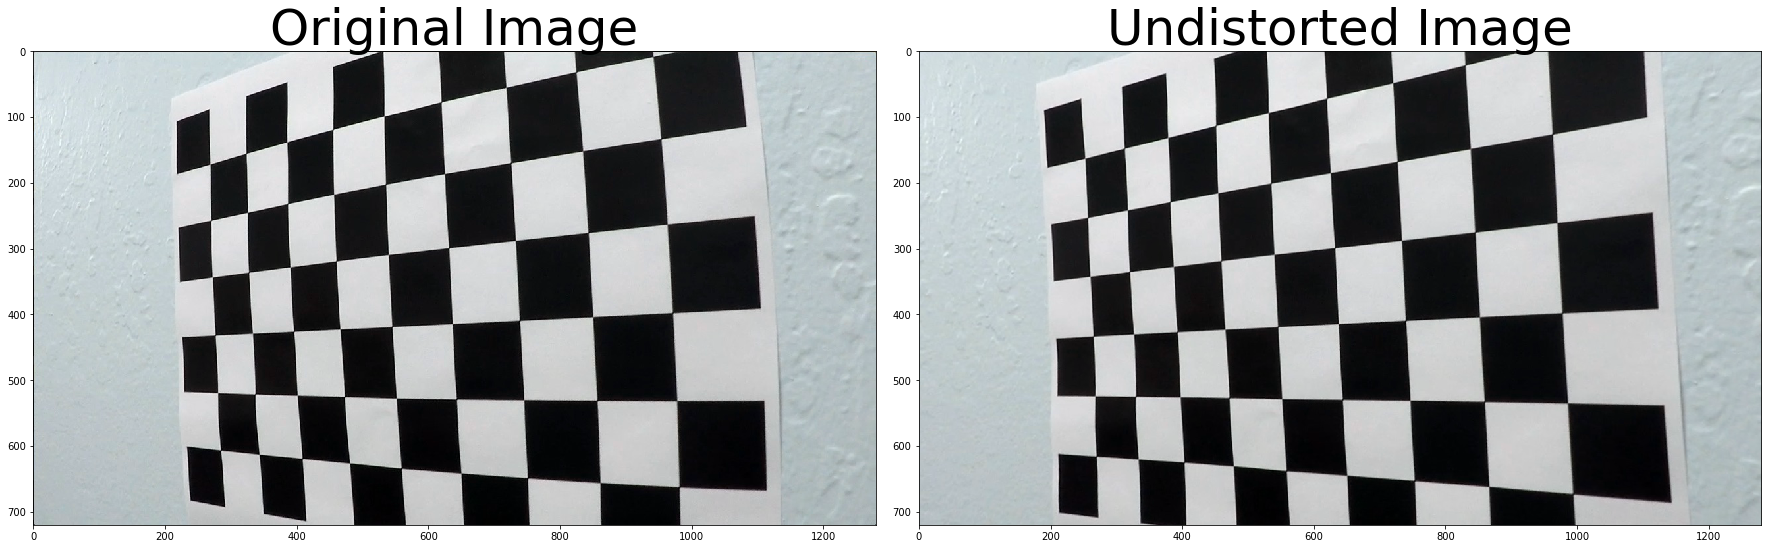

In [273]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
objpoints = dist_pickle['objpoints']
imgpoints = dist_pickle['imgpoints']
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Read in an image
img = cv2.imread('./camera_cal/calibration4.jpg')

# Function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# undistorted = cal_undistort(img, objpoints, imgpoints)
undistorted = cal_undistort(img, objpoints_org, imgpoints_org)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Transform

return of findChessboardCorners: True


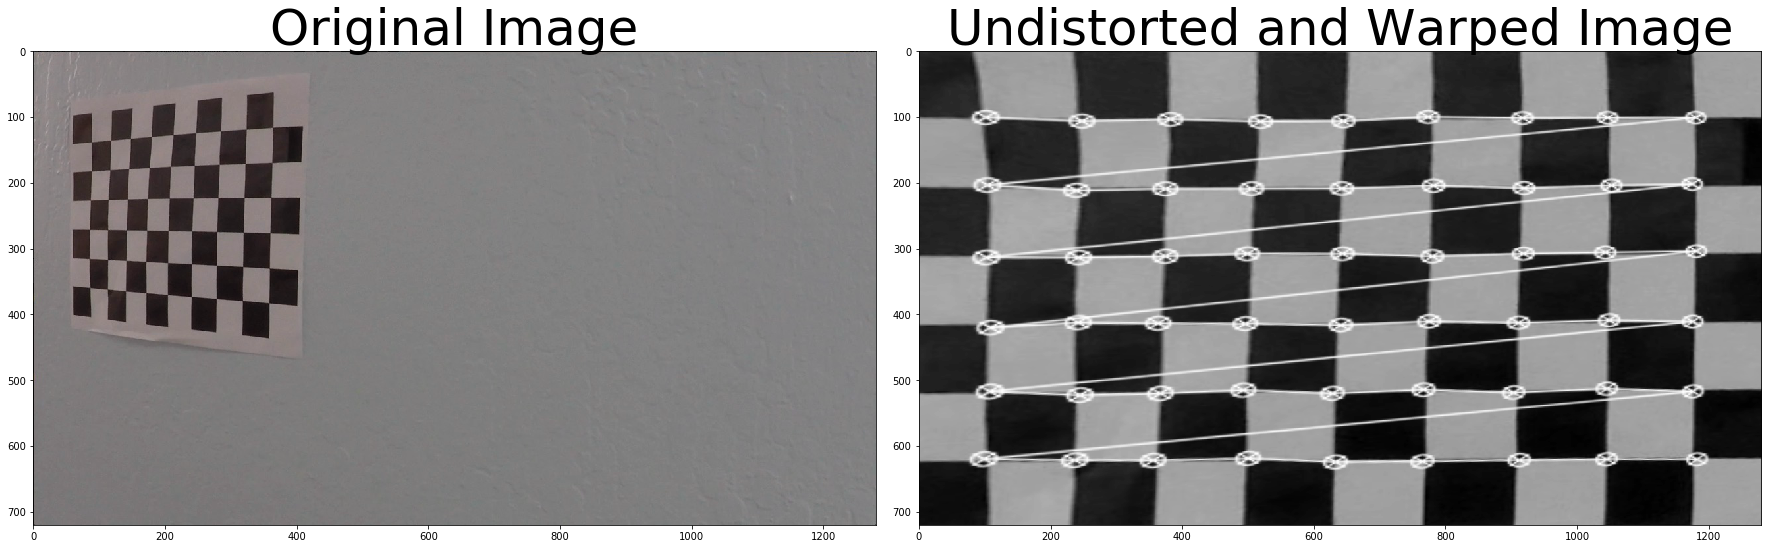

In [274]:
def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print('return of findChessboardCorners:', ret)
    warped = gray
    M = None
    if ret == True:
        offset = 100
        cv2.drawChessboardCorners(gray, (nx, ny), corners, ret)
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                         [img_size[0]-offset, img_size[1]-offset],
                         [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(gray, M, img_size, flags = cv2.INTER_LINEAR)
    return warped, M

img = cv2.imread('./camera_cal/calibration19.jpg')
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, 'gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## Applying Sobel

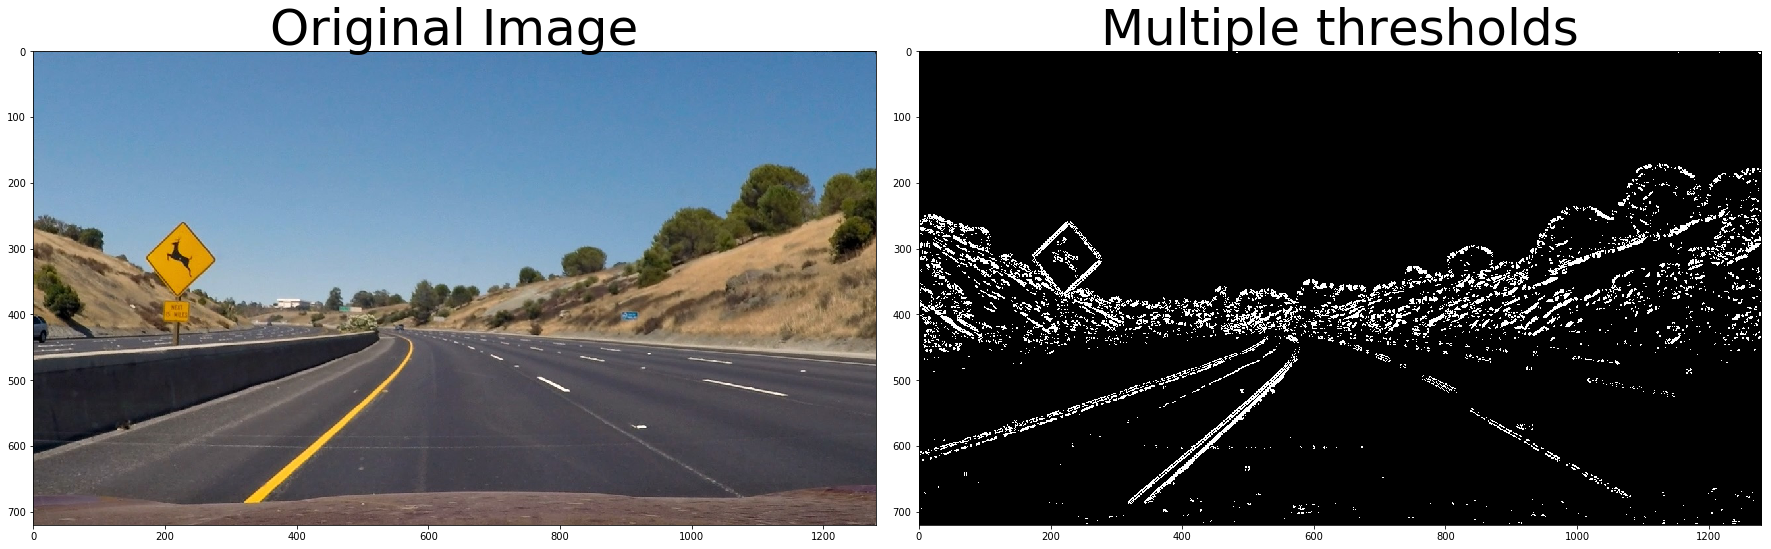

In [275]:
# Function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_binary

# Function that applies Sobel x and y
# then computes the magnatude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.power(sobelx,2) + np.power(sobely,2))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    binary_output = sbinary
    return binary_output

# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    binary_output = dir_binary
    return binary_output

# Read in an image
image = mpimg.imread('./test_images/test2.jpg')

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Multiple thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## HLS Color Threshold

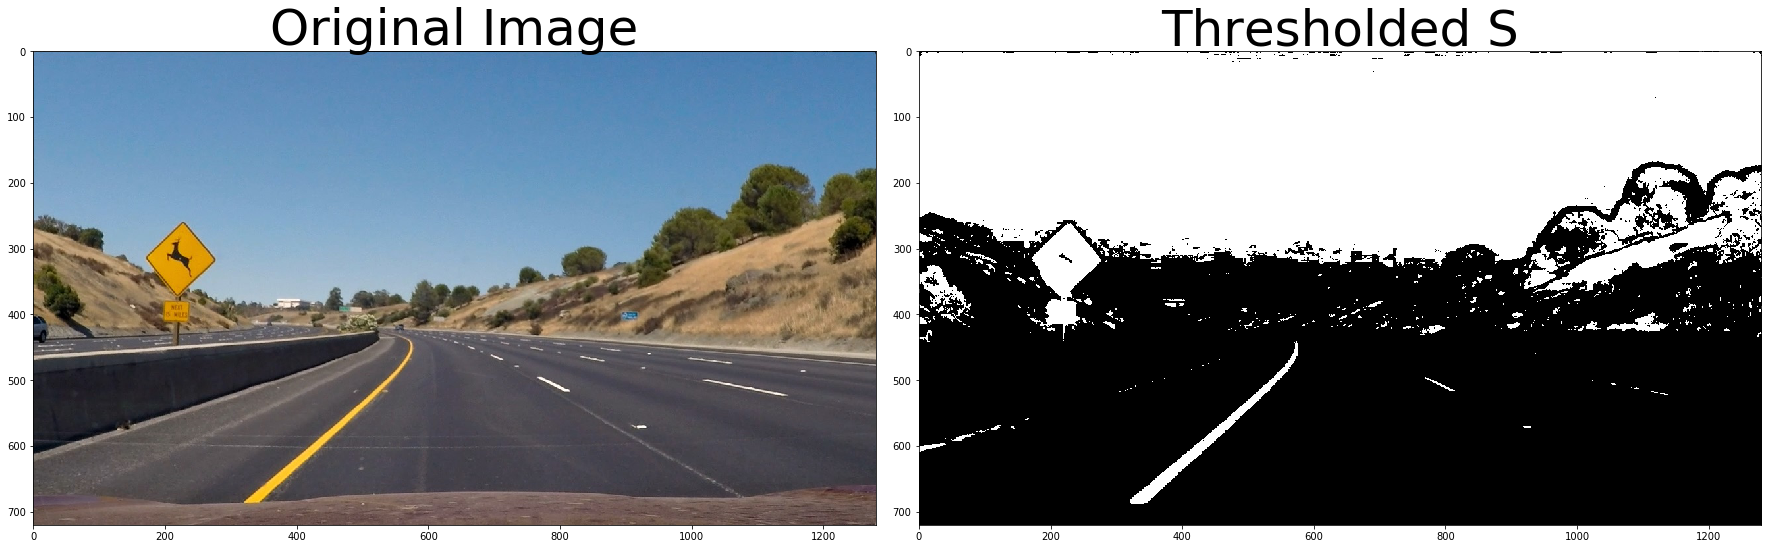

In [276]:
# Function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_binary = np.zeros_like(hls[:,:,2])
    hls_binary[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    binary_output = hls_binary
    return binary_output
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient 

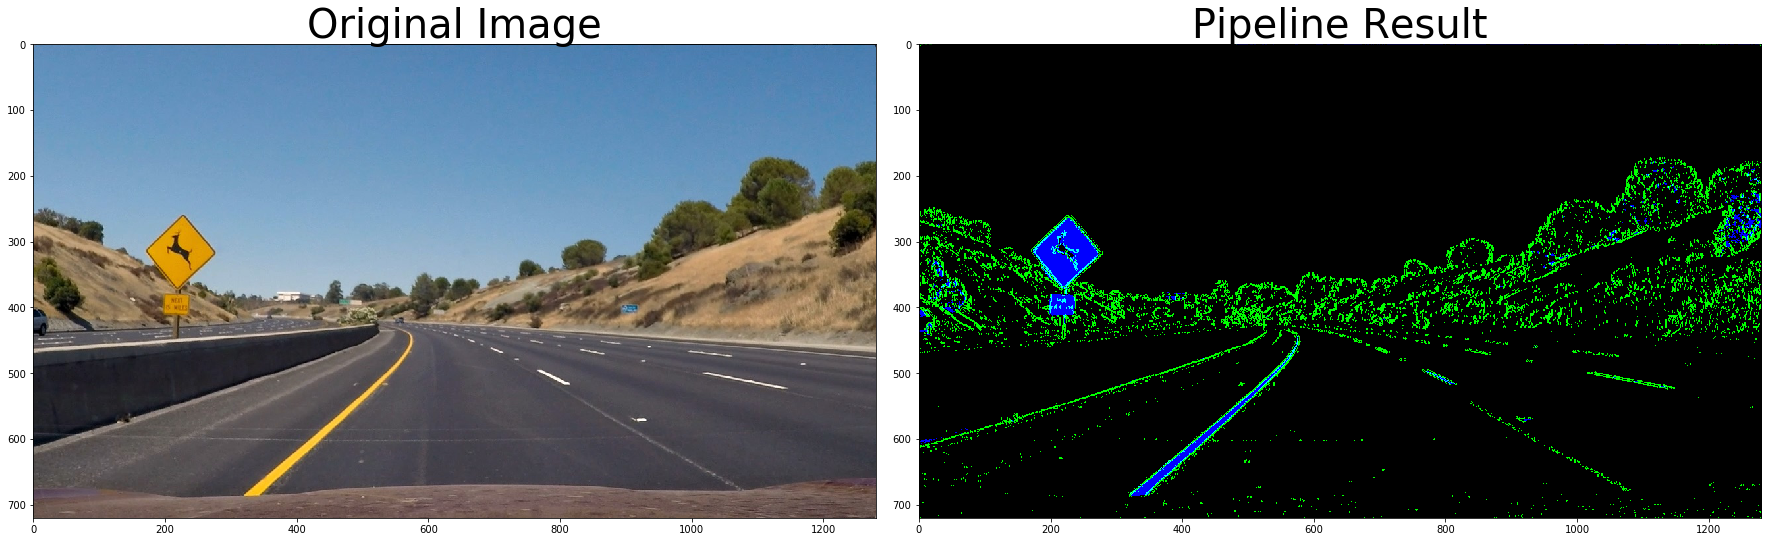

In [278]:
def gradient_color_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

image = mpimg.imread('./test_images/test2.jpg')
result = gradient_color_pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image, 'gray')
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Undistort Image

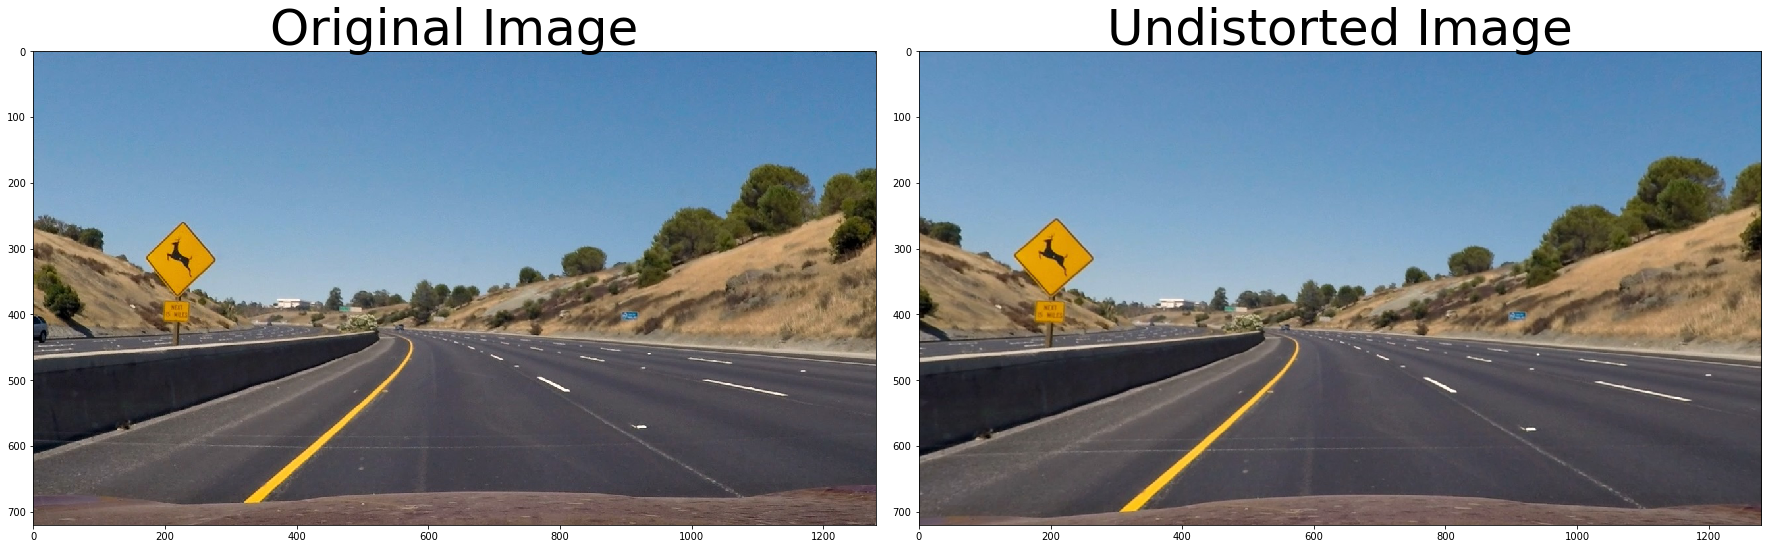

In [279]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

image = mpimg.imread('./test_images/test2.jpg')
undistorted = undistort(image, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

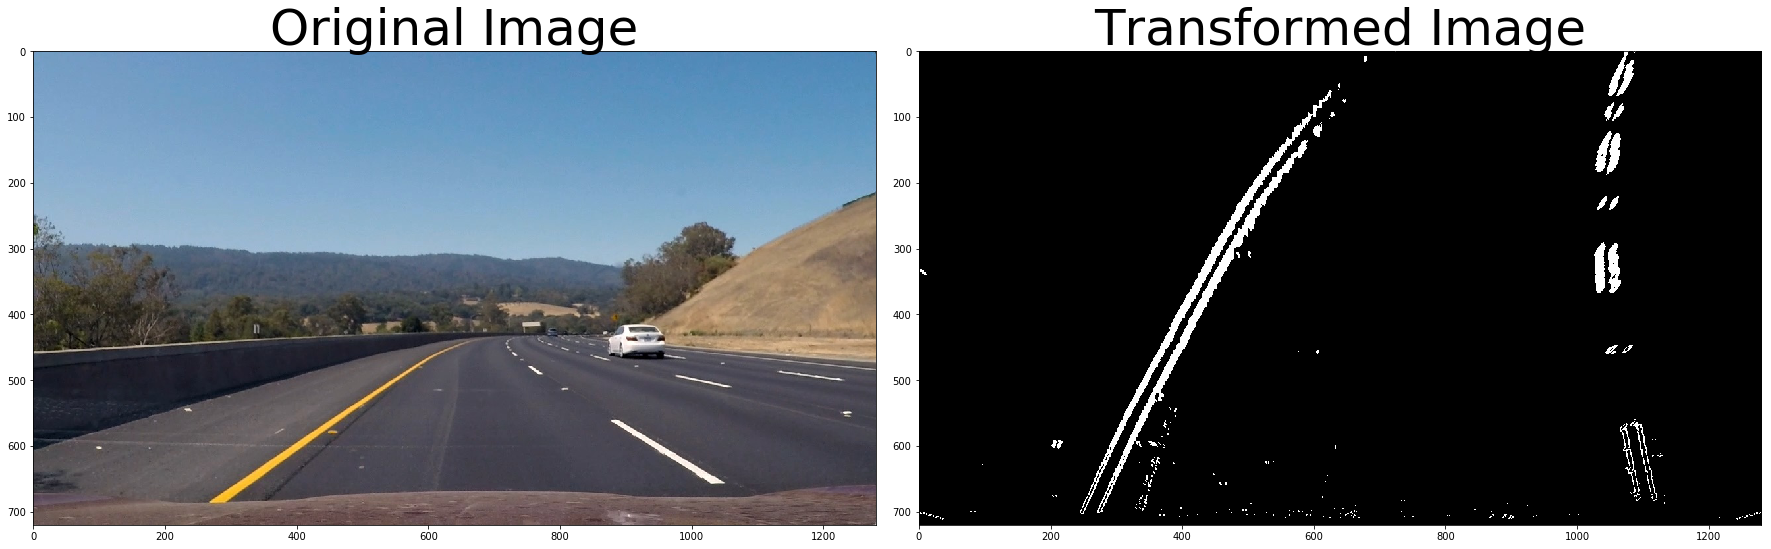

In [280]:
def transform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    return warped, M

image = mpimg.imread('./test_images/test3.jpg')
src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
dst = np.float32([[250,700],[1200,700],[250,50],[1200,50]])

combined = pipeline(image)
output = undistort(image, mtx, dist)
output, perspective_M = transform(output, src, dst)
gradx = abs_sobel_thresh(output, orient='x', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(output, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(output, sobel_kernel=15, thresh=(0.7, 1.3))
hls_binary = hls_select(output, thresh=(90, 255))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, 'gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply All Threshold

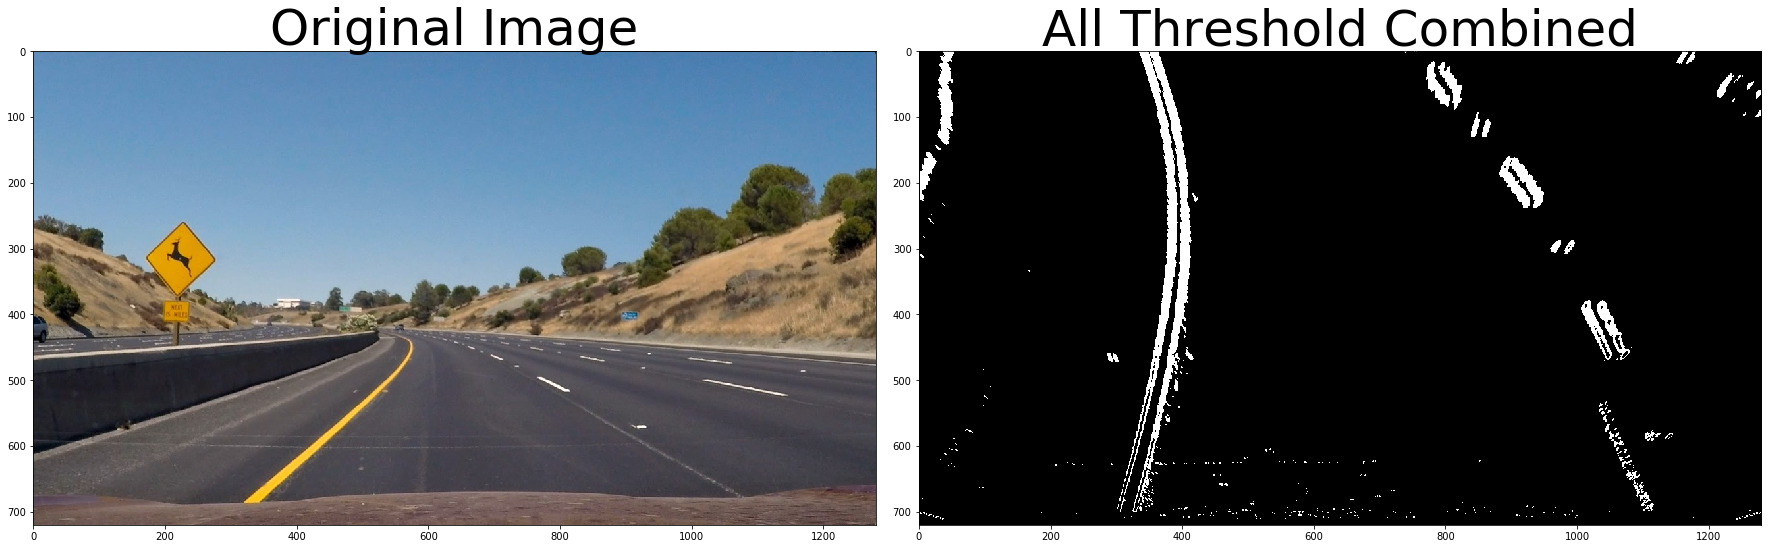

In [305]:
def pipeline(image):
    src =  np.float32([[250,700],[1200,700],[550,450],[750,450]])
    dst = np.float32([[250,700],[1200,700],[250,50],[1200,50]])

    output = undistort(image, mtx, dist)
    output, perspective_M = transform(output, src, dst)
    gradx = abs_sobel_thresh(output, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(output, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(output, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_binary = hls_select(output, thresh=(90, 255))
    combined = np.zeros_like(dir_binary, np.uint8)
    combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1))] = 1
    
    return combined;

# Read in an image
image = mpimg.imread('./test_images/test2.jpg')
output = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(output, cmap='gray')
ax2.set_title('All Threshold Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect Lane Lines

idx: 0


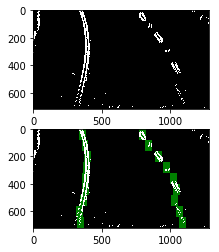

In [308]:
# window settings
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
test = 100

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), 
           max(0, int(center-width/2)):min(int(center+width/2), img_ref.shape[1])] = 1
    return output

def find_window_centroid(image, window_width, window_height, margin):
    window_centroids = [] # Store the (left, right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image scale
    # and the np.convolve the vertical image slice with the window template
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):, :int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):, int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1, (int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is 
        # at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin, 0))
        l_max_index = int(max(l_center+offset+margin, image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))
    
    return window_centroids

warped = pipeline(image)
window_centroids = find_window_centroid(warped, window_width, window_height, margin)

# If we found any window centers
idx = 0
if len(window_centroids) > 0:
    print('idx:', idx)
    idx += 1

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    warpage.astype(np.uint8)
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Dispaly the original image
plt.figure()
ax1 = plt.subplot(211)
ax1.imshow(warped, cmap='gray')

# Display the final results
ax2 = plt.subplot(212)
ax2.imshow(output)
plt.show()

## Determine Lane Curvature

In [ ]:
# To be implemented

## Build a Lane Finding Pipeline

In [11]:
def detect_lanes(image):
    return image;

## Test on Videos

In [12]:
# import eveything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    result = detect_lanes(image)
    return result

In [15]:
green_output = 'test_videos_output/greenLane.mp4'
clip2 = VideoFileClip('project_video.mp4')
green_clip = clip2.fl_image(process_image)
%time green_clip.write_videofile(green_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/greenLane.mp4
[MoviePy] Writing video test_videos_output/greenLane.mp4


100%|█████████▉| 1260/1261 [00:19<00:00, 65.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/greenLane.mp4 

CPU times: user 1.86 s, sys: 1.62 s, total: 3.48 s
Wall time: 19.8 s


In [16]:
HTML("""
<video watch="960" height="540" controls>
    <source src="{0}">
""".format(green_output))